In [1]:
%%capture
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install jiwer
!pip install wavinfo
!pip install -q transformers
!pip install pydub

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import os, sys

from pprint import pprint
import IPython

import matplotlib.pyplot as plt
import urllib.request
import soundfile as sf
import io
import librosa
import jiwer
from pydub import AudioSegment 
from tqdm import tqdm

import torch
import pandas as pd
import numpy as np

from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [3]:
ground_truth = "I like python!"
hypothesis = "i like Python?\n"

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

result = jiwer.wer(
    ground_truth, 
    hypothesis, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

In [4]:
result

1.0

## prepare dataset

In [55]:
!unzip /content/voice-text1.zip

In [6]:
list_dir, list_wav, list_text = [], [], []
for dir in os.listdir('voice-text'):

  path_etc = f'/content/voice-text/{dir}/etc/prompts-original'
  
  with open(path_etc, 'r') as f:
      for line in f.readlines():
        list_dir.append(dir)
        list_wav.append(line.split()[0])
        ln = ' '
        for st in line.split()[1:]:  
          ln += st 
          ln += ' '
        list_text.append(ln[1:-1])

In [7]:
print(len(list_wav))
print(len(list_text))
print(len(list_dir))

280
280
280


In [8]:
data_frame = pd.DataFrame([list_dir, list_wav, list_text]).T
data_frame.columns = ['author','voice', 'text']

In [9]:
data_frame.loc[0]['voice']

'rp-29'

In [10]:
# Wav2Vec pretrained model

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:358: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Taking an input value and predict
def speech2text(audio):
    # to tokens
    input_values = tokenizer(audio, return_tensors = "pt").input_values
    logits = model(input_values).logits
    prediction = torch.argmax(logits, dim = -1)
    # decode results 
    transcription = tokenizer.batch_decode(prediction)[0]
    return transcription

In [12]:
url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
response = urllib.request.urlopen(url)
audio, rate = librosa.load(io.BytesIO(response.read()), sr=16000)

In [13]:
IPython.display.Audio(data=audio, rate=rate)

In [14]:
pprint(speech2text(audio))

'I KNOW THE HUMAN BEING AND FISH CAN COEXIST PEACEFULLY'


In [15]:
spch2_text = []
for line in tqdm(data_frame.values):
  wav = line[1]
  auth = line[0]
  text = line[2]

  path_wav = f'/content/voice-text/{auth}/wav/{wav}.wav'
  audio = librosa.load(path_wav, sr=16000)[0]
  spch2_text.append(speech2text(audio))

100%|██████████| 280/280 [07:38<00:00,  1.64s/it]


In [16]:
data_frame['speech2text'] = pd.DataFrame(spch2_text)
data_frame['speech2text'] = data_frame['speech2text'].apply(lambda x: x.lower())
data_frame['text'] = data_frame['text'].apply(lambda x: x.lower())

In [17]:
data_frame

,author,voice,text,speech2text
0,1028-20100710-hne,rp-29,since red and green light when mixed form yellow.,since red and green light when mixed form yellow
1,1028-20100710-hne,rp-30,"this is a very common type of bow, one showing...",this is a very common type of bau one showing ...
2,1028-20100710-hne,rp-31,with little or no green or blue.,with little or no green or blue
3,1028-20100710-hne,ar-01,once there was a young rat named arthur who ne...,once there was a young rat named arthur who ne...
4,1028-20100710-hne,ar-02,whenever his friends asked him if he would lik...,whenever his friends asked him if he would lik...
...,...,...,...,...
275,Airwings-20101216-vqx,ar-23,in the foggy morning some men with some boys a...,in the fuggy morning some men with some boys a...
276,Airwings-20101216-vqx,ar-24,one of them moved a board and saw a rat quite ...,one of them moved aboard and saw a rot quite d...
277,Airwings-20101216-vqx,rb-01,hand-held devices such as personal digital ass...,and held device such as personal vigital assis...
278,Airwings-20101216-vqx,rb-02,most of them use either a touch screen interfa...,most of them use either a dutch screen interfa...


In [18]:
wer, mer, wil, fuz = [], [], [], []
for line in tqdm(data_frame.values):
  text = line[2]
  hypothesis = line[3]

  fuz.append(fuzz.WRatio(text, hypothesis))


  measures = jiwer.compute_measures(text, hypothesis)
  wer.append(measures['wer'])
  mer.append(measures['mer'])
  wil.append(measures['wil'])


100%|██████████| 280/280 [00:00<00:00, 9978.46it/s]


In [19]:
data_frame['fuz_levenshtein'] = pd.DataFrame(fuz)
data_frame['wer'] = pd.DataFrame(wer)
data_frame['mer'] = pd.DataFrame(mer)
data_frame['wil'] = pd.DataFrame(wil)


In [20]:
data_frame

,author,voice,text,speech2text,fuz_levenshtein,wer,mer,wil
0,1028-20100710-hne,rp-29,since red and green light when mixed form yellow.,since red and green light when mixed form yellow,100,0.111111,0.111111,0.209877
1,1028-20100710-hne,rp-30,"this is a very common type of bow, one showing...",this is a very common type of bau one showing ...,96,0.142857,0.142857,0.265306
2,1028-20100710-hne,rp-31,with little or no green or blue.,with little or no green or blue,100,0.142857,0.142857,0.265306
3,1028-20100710-hne,ar-01,once there was a young rat named arthur who ne...,once there was a young rat named arthur who ne...,100,0.066667,0.066667,0.128889
4,1028-20100710-hne,ar-02,whenever his friends asked him if he would lik...,whenever his friends asked him if he would lik...,100,0.071429,0.071429,0.137755
...,...,...,...,...,...,...,...,...
275,Airwings-20101216-vqx,ar-23,in the foggy morning some men with some boys a...,in the fuggy morning some men with some boys a...,95,0.222222,0.222222,0.395062
276,Airwings-20101216-vqx,ar-24,one of them moved a board and saw a rat quite ...,one of them moved aboard and saw a rot quite d...,89,0.450000,0.450000,0.644118
277,Airwings-20101216-vqx,rb-01,hand-held devices such as personal digital ass...,and held device such as personal vigital assis...,94,0.666667,0.571429,0.785714
278,Airwings-20101216-vqx,rb-02,most of them use either a touch screen interfa...,most of them use either a dutch screen interfa...,92,0.312500,0.294118,0.470588


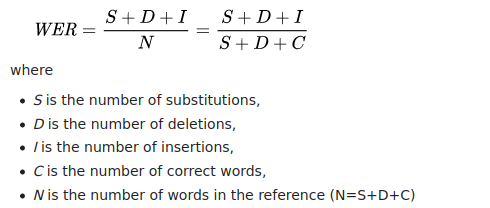

In [21]:
# Word Error Rate
data_frame.wer.describe()

count    280.000000
mean       0.264758
std        0.195373
min        0.000000
25%        0.111111
50%        0.200000
75%        0.363636
max        1.142857
Name: wer, dtype: float64

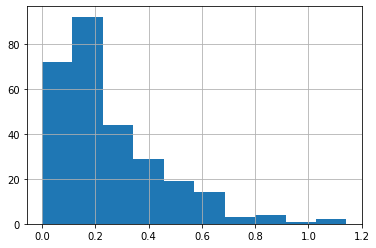

In [22]:
data_frame.wer.hist()

In [23]:
# Match Error Rate
data_frame.mer.describe()

count    280.000000
mean       0.254031
std        0.175585
min        0.000000
25%        0.111111
50%        0.200000
75%        0.333333
max        1.000000
Name: mer, dtype: float64

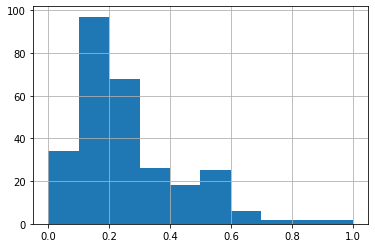

In [24]:
data_frame.mer.hist()

In [25]:
# Word Information Lost
data_frame.wil.describe()

count    280.000000
mean       0.403221
std        0.214970
min        0.000000
25%        0.209877
50%        0.360000
75%        0.553815
max        1.000000
Name: wil, dtype: float64

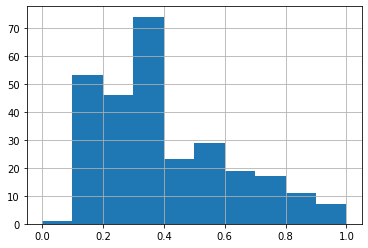

In [26]:
data_frame.wil.hist()

In [27]:
# fuz levenshtein distance
data_frame.fuz_levenshtein.describe()

count    280.000000
mean      96.507143
std        5.535803
min       65.000000
25%       95.000000
50%       99.000000
75%      100.000000
max      100.000000
Name: fuz_levenshtein, dtype: float64

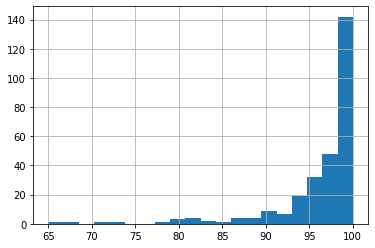

In [28]:
data_frame.fuz_levenshtein.hist(bins=20)

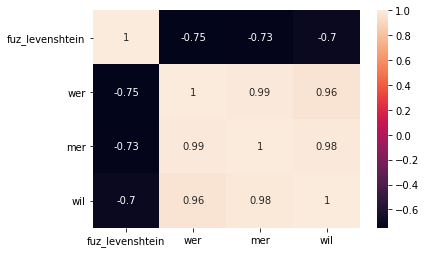

In [29]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(data_frame.corr(), annot=True)
plt.show()

In [30]:
errors = data_frame[data_frame.fuz_levenshtein < 80]
errors

,author,voice,text,speech2text,fuz_levenshtein,wer,mer,wil
50,BhushanNKIITBombay-20140219-bbj,b0425,"there were orange-green, gold-green, and a cop...",tere were orinscreen borlgreen and o offergren...,67,1.142857,0.800000,0.942857
52,BhushanNKIITBombay-20140219-bbj,b0427,the sunsets grow more bizarre and spectacular ...,te sensec go more of azari an spectacor of tis...,73,0.846154,0.785714,0.950549
53,BhushanNKIITBombay-20140219-bbj,b0428,the history of our westward-faring race is wri...,the history all for thisbirg far is is ritinin...,65,0.700000,0.700000,0.910000
54,BhushanNKIITBombay-20140219-bbj,b0429,and the eurasian chinese-englishman bowed hims...,ande youresian shinas englishman or hamsen of i,71,1.142857,1.000000,1.000000
88,Airwings-20101216-zul,b0300,does the old boy often go off at half-cock tha...,does the hull boy huff and go huff at hascok t...,79,0.545455,0.500000,0.727273
157,23yipikaye-20100807-ujm,b0319,"daylight was tired, profoundly tired.",dilike was tired provenly tired,78,0.800000,0.800000,0.960000


In [31]:
# indian 
path_wav = f'/content/voice-text/BhushanNKIITBombay-20140219-bbj/wav/b0425.wav'
audio, rate = librosa.load(path_wav, sr=16000)
IPython.display.Audio(data=audio, rate=rate)

In [32]:
print('Original :' ,errors[errors['voice'] == 'b0425']['text'].values[0])
print('Hypotesis :',errors[errors['voice'] == 'b0425']['speech2text'].values[0])

Original : there were orange-green, gold-green, and a copper-green.
Hypotesis : tere were orinscreen borlgreen and o offergren on the fevol


In [33]:
path_wav = f'/content/voice-text/BhushanNKIITBombay-20140219-bbj/wav/b0428.wav'
audio, rate = librosa.load(path_wav, sr=16000)
IPython.display.Audio(data=audio, rate=rate)

In [34]:
print('Original :' ,errors[errors['voice'] == 'b0428']['text'].values[0])
print('Hypotesis :',errors[errors['voice'] == 'b0428']['speech2text'].values[0])

Original : the history of our westward-faring race is written in it.
Hypotesis : the history all for thisbirg far is is ritininit  of


In [35]:
# asian
path_wav = f'/content/voice-text/23yipikaye-20100807-ujm/wav/b0319.wav'
audio, rate = librosa.load(path_wav, sr=16000)
IPython.display.Audio(data=audio, rate=rate)

In [36]:
print('Original :' ,errors[errors['voice'] == 'b0319']['text'].values[0])
print('Hypotesis :',errors[errors['voice'] == 'b0319']['speech2text'].values[0])

Original : daylight was tired, profoundly tired.
Hypotesis : dilike was tired provenly tired


In [37]:
# British accent ??? France??
path_wav = f'/content/voice-text/Airwings-20101216-zul/wav/b0300.wav'
audio, rate = librosa.load(path_wav, sr=16000)
IPython.display.Audio(data=audio, rate=rate)

In [38]:
print('Original :' ,errors[errors['voice'] == 'b0300']['text'].values[0])
print('Hypotesis :',errors[errors['voice'] == 'b0300']['speech2text'].values[0])

Original : does the old boy often go off at half-cock that way.
Hypotesis : does the hull boy huff and go huff at hascok that way


### Denoiser
### Dual-signal Transformation LSTM Network
### Levenshtein metrics after denoise

This approach combines a short-time Fourier transform (STFT) and a learned analysis and synthesis basis in a stacked-network approach with less than one million parameters. The model was trained on 500h of noisy speech provided by the challenge organizers. The network is capable of real-time processing (one frame in, one frame out) and reaches competitive results. Combining these two types of signal transformations enables the DTLN to robustly extract information from magnitude spectra and incorporate phase information from the learned feature basis. The method shows state-of-the-art performance and outperforms the DNS-Challenge baseline by 0.24 points absolute in terms of the mean opinion score (MOS).



In [39]:
# !git clone https://github.com/breizhn/DTLN.git

In [ ]:
%cd DTLN/

/content/DTLN


In [ ]:
!python3 run_evaluation.py -i /content/voice-text/wav/ -o /content/voice-text/clear_wav/ -m ./pretrained_model/model.h5

2021-04-20 04:07:35.374543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-20 04:07:36.588461: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-20 04:07:36.589231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-20 04:07:36.618909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-20 04:07:36.619592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-04-20 04:07:36.619662: I tensorflow/stream_executor/platform/default/dso_loade

In [45]:
spch2_text = []
for line in tqdm(data_frame.values):
  wav = line[1]
  auth = line[0]
  text = line[2]

  path_wav = f'/content/voice-text/{auth}/wav/{wav}.wav'
  audio = librosa.load(path_wav, sr=16000)[0]
  spch2_text.append(speech2text(audio))

100%|██████████| 260/260 [06:55<00:00,  1.60s/it]


In [46]:
data_frame['speech2text'] = pd.DataFrame(spch2_text)
data_frame['speech2text'] = data_frame['speech2text'].apply(lambda x: x.lower())
data_frame['text'] = data_frame['text'].apply(lambda x: x.lower())

In [47]:
wer, mer, wil, fuz = [], [], [], []
for line in tqdm(data_frame.values):
  text = line[2]
  hypothesis = line[3]

  fuz.append(fuzz.WRatio(text, hypothesis))


  measures = jiwer.compute_measures(text, hypothesis)
  wer.append(measures['wer'])
  mer.append(measures['mer'])
  wil.append(measures['wil'])

100%|██████████| 260/260 [00:00<00:00, 9764.76it/s]


In [48]:
data_frame['fuz_levenshtein'] = pd.DataFrame(fuz)
data_frame['wer'] = pd.DataFrame(wer)
data_frame['mer'] = pd.DataFrame(mer)
data_frame['wil'] = pd.DataFrame(wil)

In [49]:
data_frame.wer.describe()

count    260.000000
mean       0.273795
std        0.198933
min        0.000000
25%        0.125000
50%        0.200000
75%        0.366477
max        1.142857
Name: wer, dtype: float64

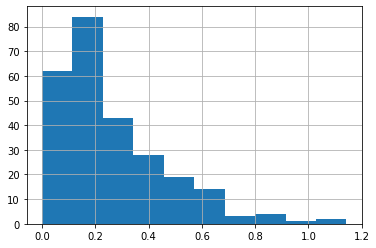

In [50]:
data_frame.wer.hist()

In [51]:
data_frame.mer.describe()

count    260.000000
mean       0.262330
std        0.178512
min        0.000000
25%        0.125000
50%        0.200000
75%        0.358766
max        1.000000
Name: mer, dtype: float64

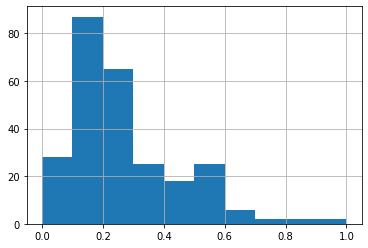

In [52]:
data_frame.mer.hist()

In [53]:
# fuz levenshtein distance
data_frame.fuz_levenshtein.describe()

count    260.000000
mean      96.276923
std        5.673232
min       65.000000
25%       95.000000
50%       98.000000
75%      100.000000
max      100.000000
Name: fuz_levenshtein, dtype: float64

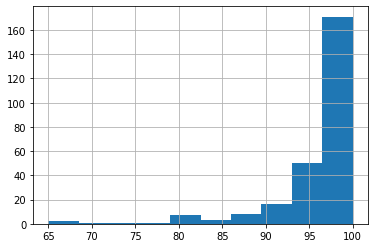

In [54]:
# fuz levenshtein distance
data_frame.fuz_levenshtein.hist()